In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Função para construir o modelo Unet
def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv4])
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv3])
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = layers.concatenate([up8, conv2])
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1])
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Função para carregar o dataset de imagens e máscaras
def load_dataset(path_to_images_x, path_to_images_y):
    images = []
    masks = []

    for img_file in os.listdir(path_to_images_x):
        if img_file.endswith('_x.png'):
            # Carregar imagem térmica e máscara correspondente
            img_x = cv2.imread(os.path.join(path_to_images_x, img_file))
            img_y = cv2.imread(os.path.join(path_to_images_y, img_file.replace('_x.png', '_y.png')))

            # Redimensionar para 128x128 se necessário
            img_x = cv2.resize(img_x, (128, 128))
            img_y = cv2.resize(img_y, (128, 128))

            # Normalizar as imagens
            img_x = img_x / 255.0
            img_y = img_y[:, :, 0]  # Apenas o canal de máscara (supondo que a máscara é uma imagem binária)

            # Adicionar as imagens e máscaras à lista
            images.append(img_x)
            masks.append(img_y)

    images = np.array(images)
    masks = np.array(masks).reshape(-1, 128, 128, 1)  # Máscaras devem ter a forma (batch_size, altura, largura, canais)

    return images, masks

# Diretórios
path_to_images_x = "/content/drive/MyDrive/OrganizedImages/Matched/data/images/train"
path_to_images_y = "/content/drive/MyDrive/OrganizedImages/Matched/Y"

# Carregar o dataset
images, masks = load_dataset(path_to_images_x, path_to_images_y)

# Dividir em conjunto de treino e validação
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Criar o modelo Unet
model = unet_model()

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=8, validation_data=(X_val, y_val))

# Salvar o modelo treinado
model.save("/content/drive/MyDrive/OrganizedImages/Matched/unet_eyes_segmentation.h5")


Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 94s 309ms/step - accuracy: 0.4452 - loss: nan - val_accuracy: 0.6034 - val_loss: nan
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 82s 129ms/step - accuracy: 0.6079 - loss: nan - val_accuracy: 0.6034 - val_loss: nan
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 40s 126ms/step - accuracy: 0.6107 - loss: nan - val_accuracy: 0.6034 - val_loss: nan
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 41s 125ms/step - accuracy: 0.6017 - loss: nan - val_accuracy: 0.6034 - val_loss: nan
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 28s 129ms/step - accuracy: 0.6089 - loss: nan - val_accuracy: 0.6034 - val_loss: nan
Epoch 6/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 40s 125ms/step - accuracy: 0.6026 - loss: nan - val_accuracy: 0.6034 - val_loss: nan
Epoch 7/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 42s 130ms/step - accuracy: 0.6065 - loss: nan - val_accuracy: 0.6034 - val_loss: nan
Epoch 8/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 27s 125ms/step - accuracy: 0.6017 - loss: nan - val_accuracy: 0.6034 - val_loss: nan


Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 47s 168ms/step - accuracy: 0.6615 - iou: 0.3111 - loss: 0.6158 - val_accuracy: 0.8460 - val_iou: 0.5570 - val_loss: 0.3658
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - accuracy: 0.8440 - iou: 0.5454 - loss: 0.3680 - val_accuracy: 0.8436 - val_iou: 0.5193 - val_loss: 0.3647
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - accuracy: 0.8416 - iou: 0.5377 - loss: 0.3706 - val_accuracy: 0.8464 - val_iou: 0.5619 - val_loss: 0.3654
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - accuracy: 0.8410 - iou: 0.5386 - loss: 0.3753 - val_accuracy: 0.8449 - val_iou: 0.5664 - val_loss: 0.3663
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.8454 - iou: 0.5485 - loss: 0.3620 - val_accuracy: 0.8473 - val_iou: 0.5937 - val_loss: 0.3619
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - accuracy: 0.8469 - iou: 0.5509 - loss: 0.3601 - val_accuracy: 0.8443 - val_iou: 0.6036 - val_loss: 0.3815
Epoch 7/10
213/213 ━━━

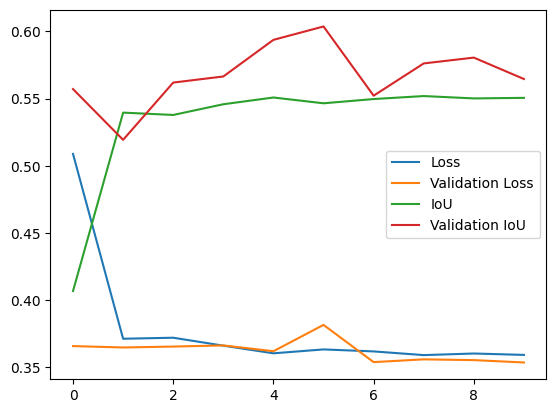

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Função para calcular o IoU (Intersection over Union) corrigida
def iou(y_true, y_pred, smooth=1e-6):
    # Converter y_true para float32 para combinar com y_pred
    y_true = tf.cast(y_true, tf.float32)

    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

# Caminhos para as imagens
path_to_images_x = "/content/drive/MyDrive/OrganizedImages/Matched/data/images/train"
path_to_images_y = "/content/drive/MyDrive/OrganizedImages/Matched/Y"

# Função para carregar imagens e máscaras
def load_images_and_masks(img_dir_x, img_dir_y):
    images = []
    masks = []

    for img_file in os.listdir(img_dir_x):
        if img_file.endswith('_x.png'):
            img_x_path = os.path.join(img_dir_x, img_file)
            img_y_path = os.path.join(img_dir_y, img_file.replace('_x.png', '_y.png'))

            img_x = cv2.imread(img_x_path, cv2.IMREAD_GRAYSCALE)  # Imagem térmica
            img_y = cv2.imread(img_y_path, cv2.IMREAD_GRAYSCALE)  # Máscara (olhos segmentados em vermelho)

            if img_x is not None and img_y is not None:
                # Redimensionar para manter as dimensões consistentes, caso necessário
                img_x = cv2.resize(img_x, (128, 128))
                img_y = cv2.resize(img_y, (128, 128))

                # Normalizar as imagens (somente img_x precisa de normalização, img_y será binarizada)
                img_x = img_x / 255.0
                img_y = np.where(img_y > 128, 1, 0)  # Binarizando a máscara para garantir valores 0 ou 1

                images.append(img_x)
                masks.append(img_y)

    images = np.array(images).reshape(-1, 128, 128, 1)
    masks = np.array(masks).reshape(-1, 128, 128, 1)

    return images, masks

# Carregar imagens e máscaras
images, masks = load_images_and_masks(path_to_images_x, path_to_images_y)

# Dividir o dataset em treino e validação
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Definir a arquitetura U-Net
def unet_model(input_size=(128, 128, 1)):
    inputs = layers.Input(input_size)

    # Encoder (contração)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder (expansão)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

# Compilar o modelo
model = unet_model()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou])

# Treinamento do modelo
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=8, epochs=10)

# Visualizar a performance do modelo
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['iou'], label='IoU')
plt.plot(history.history['val_iou'], label='Validation IoU')
plt.legend()
plt.show()

# Salvar o modelo treinado
model.save('/content/drive/MyDrive/OrganizedImages/Matched/models/unet_eyes_segmentation_v2.h5')
